<a href="https://colab.research.google.com/github/Faareh-Ahmed/Segment-Green-Spaces/blob/main/ClipImage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 51.5 MB/s eta 0:00:00


In [8]:
import rasterio
from rasterio.windows import Window
import matplotlib.pyplot as plt
import os
import numpy as np


In [4]:
# File paths
input_tif = "/content/2018-12-17.tif"
output_dir = "/content/clipped_segments/"
os.makedirs(output_dir, exist_ok=True)

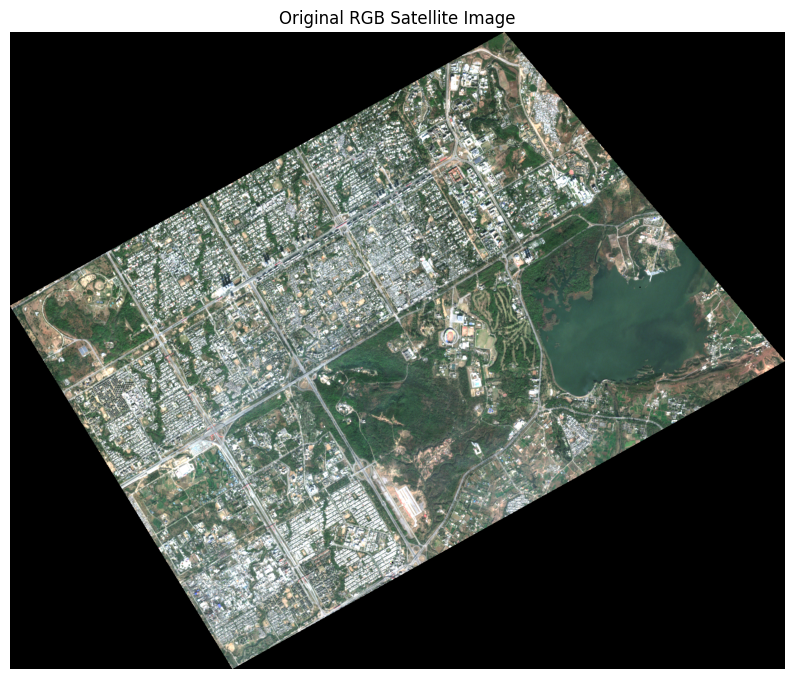

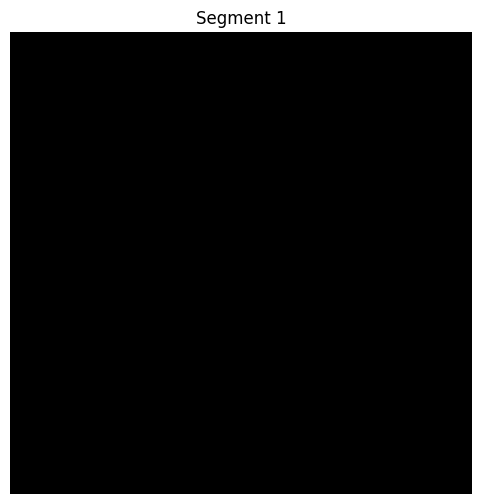

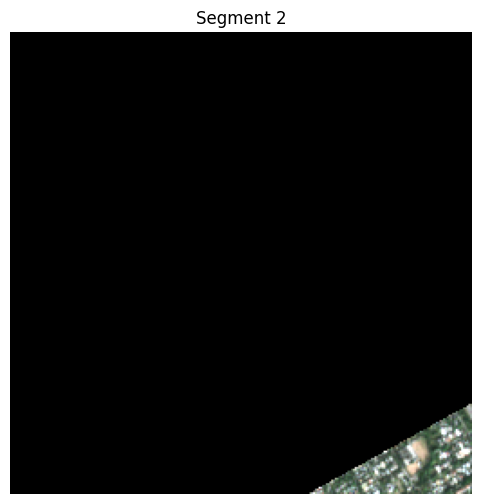

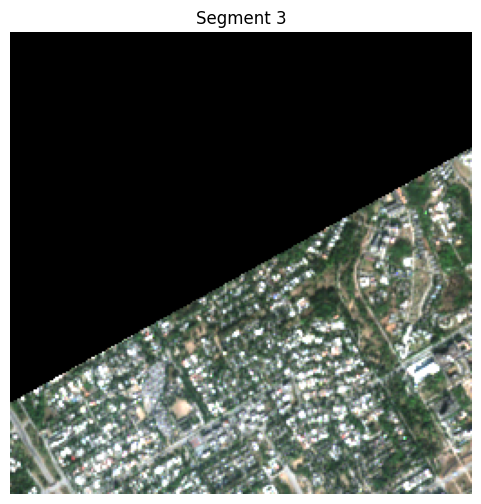

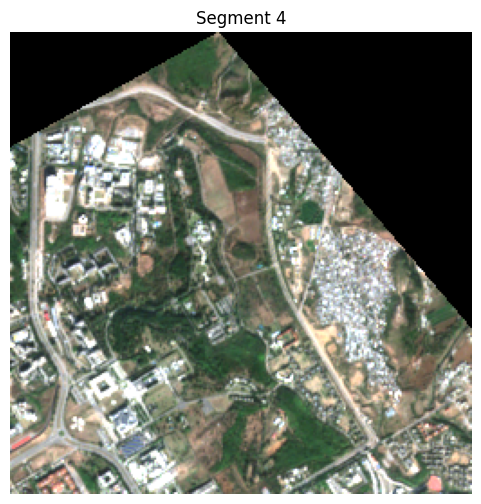

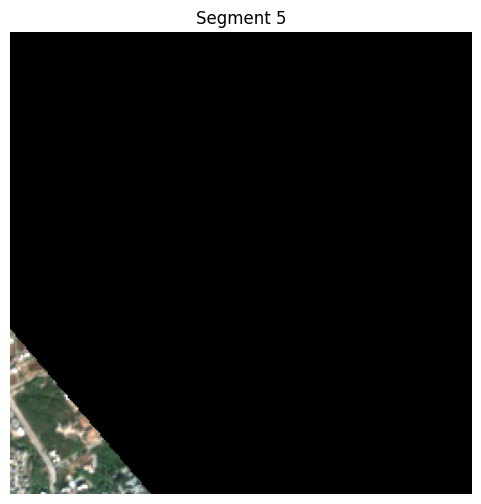

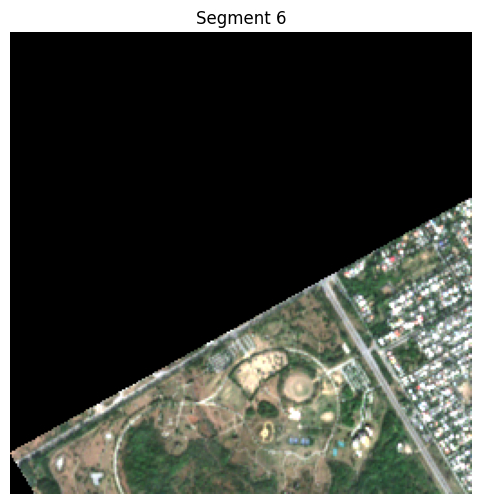

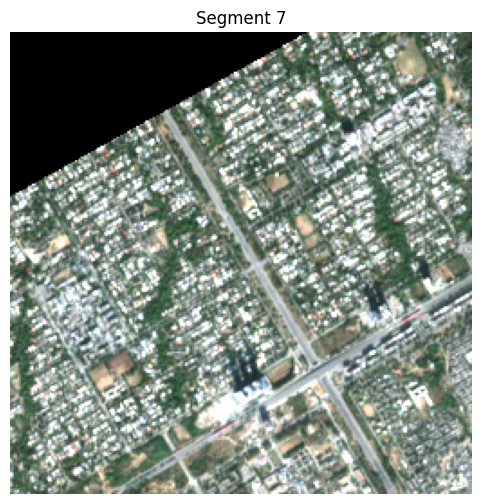

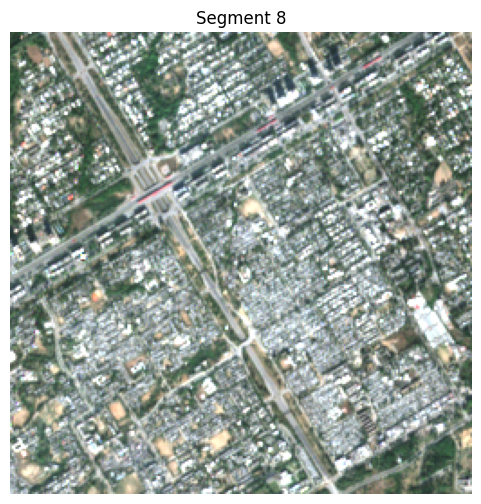

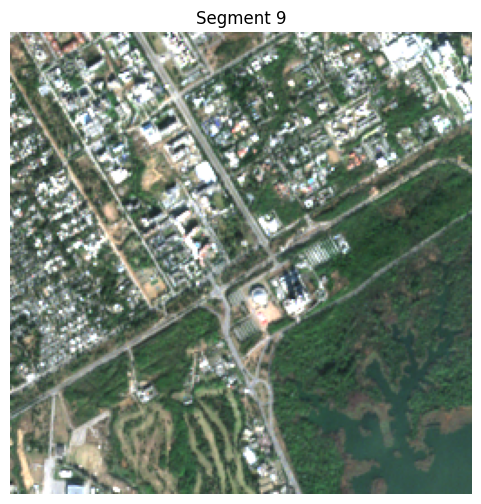

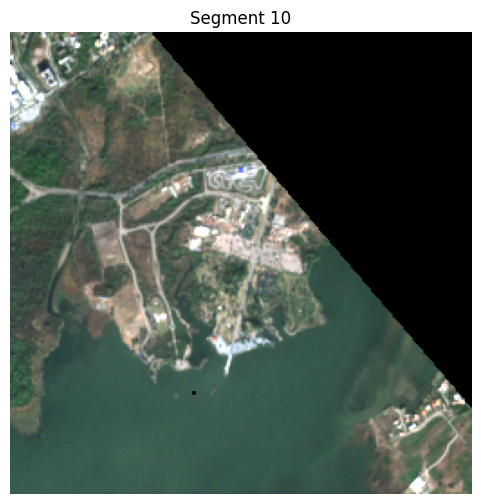

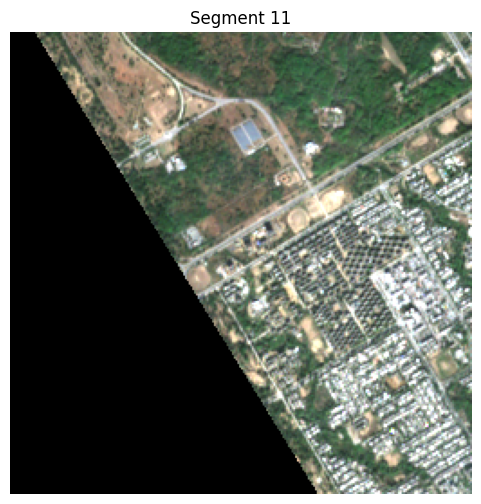

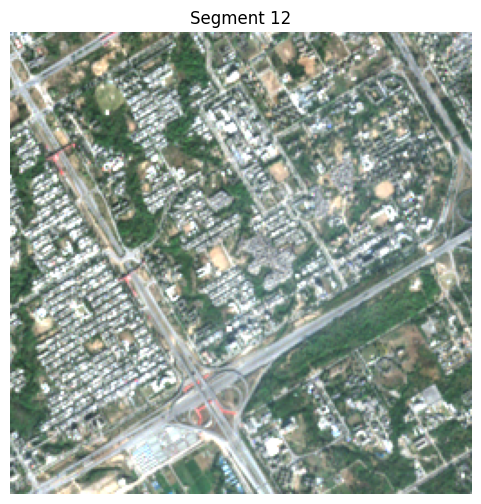

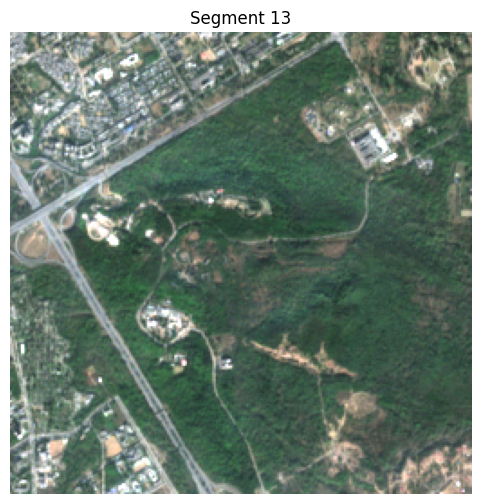

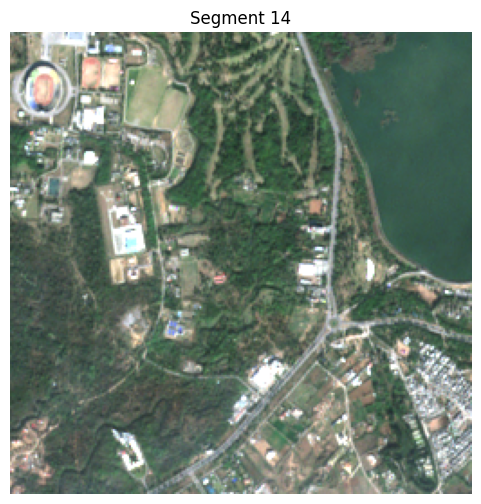

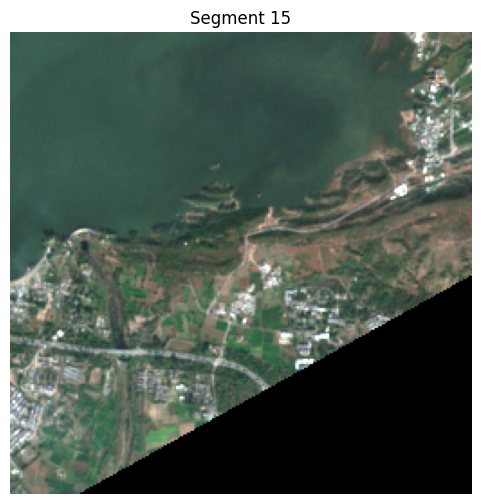

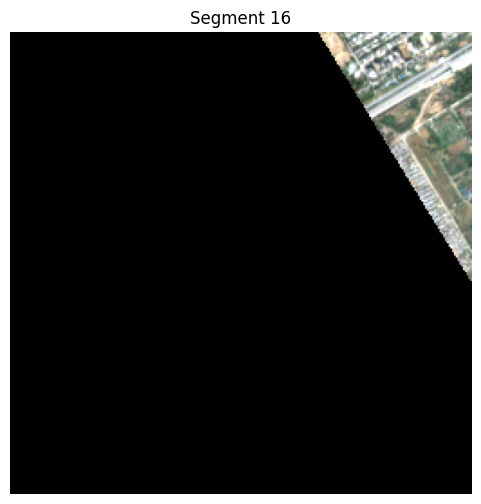

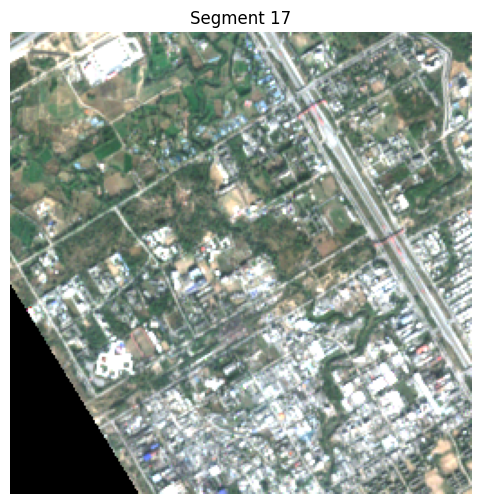

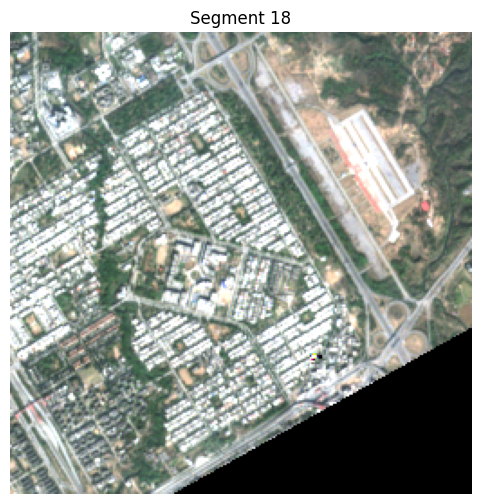

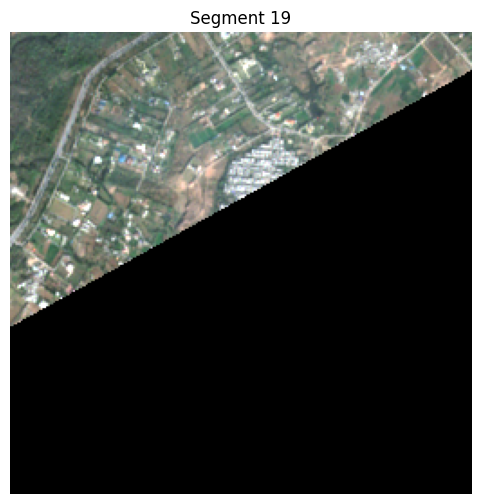

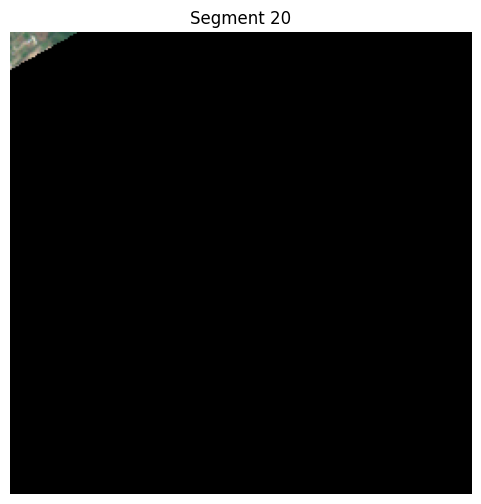

Clipping completed! Total segments generated: 20
Segments saved in: /content/clipped_segments/


In [19]:
# Parameters
segment_size = 256  # Smaller size means higher zoom level
step_size = segment_size  # Overlap between segments to increase the number of clipped images

with rasterio.open(input_tif) as src:
    # Read all three RGB bands
    image = src.read([1, 2, 3])  # RGB bands

    # Display the full RGB image
    rgb_image = np.stack([image[0], image[1], image[2]], axis=-1)  # Combine RGB bands
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb_image)
    plt.title("Original RGB Satellite Image")
    plt.axis("off")
    plt.show()

    # Step 2: Clip the image into smaller zoomed-in RGB segments
    count = 0

    for i in range(0, src.height - segment_size + 1, step_size):
        for j in range(0, src.width - segment_size + 1, step_size):
            # Define the window for clipping
            window = Window(j, i, segment_size, segment_size)
            transform = src.window_transform(window)

            # Read the window data for all bands (RGB)
            segment = src.read([1, 2, 3], window=window)  # RGB data

            # Save the segment as a new .tif file
            output_path = os.path.join(output_dir, f"segment_{count}.tif")
            with rasterio.open(
                output_path,
                "w",
                driver="GTiff",
                height=segment.shape[1],
                width=segment.shape[2],
                count=3,  # RGB
                dtype=segment.dtype,
                crs=src.crs,
                transform=transform,
            ) as dest:
                dest.write(segment)

            count += 1

            # Optional: Display each segment (Uncomment to visualize)
            segment_rgb = np.stack([segment[0], segment[1], segment[2]], axis=-1)
            plt.figure(figsize=(6, 6))
            plt.imshow(segment_rgb)
            plt.title(f"Segment {count}")
            plt.axis("off")
            plt.show()

print(f"Clipping completed! Total segments generated: {count}")
print(f"Segments saved in: {output_dir}")

In [24]:
import rasterio
import numpy as np
import glob
from rasterio.transform import from_origin

# Parameters
clipped_dir = "/content/clipped_segments/"  # Directory containing clipped images
output_zoomed_tif = "/content/zoomed_original.tif"  # Output file for zoomed-in image
segment_size = 256  # Same segment size used for clipping
step_size = segment_size  # Same step size used for clipping

# Step 1: Get all clipped segments and sort by filename (to ensure correct order)
clipped_files = sorted(glob.glob(f"{clipped_dir}/*.tif"))

# Step 2: Calculate the dimensions of the zoomed image
# Assuming the original image dimensions and clipping parameters are consistent
num_segments = len(clipped_files)
rows = int(np.sqrt(num_segments))  # Number of rows of tiles
cols = rows  # Number of columns of tiles (assumes square grid)
height = rows * segment_size
width = cols * segment_size

# Step 3: Initialize an empty array for the zoomed image
zoomed_image = np.zeros((3, height, width), dtype=np.uint8)  # RGB image

# Step 4: Reconstruct the image by placing each tile in the correct position
index = 0
for row in range(rows):
    for col in range(cols):
        if index < len(clipped_files):
            with rasterio.open(clipped_files[index]) as src:
                segment = src.read([1, 2, 3])  # Read RGB channels
                start_row = row * segment_size
                start_col = col * segment_size
                zoomed_image[:, start_row:start_row+segment_size, start_col:start_col+segment_size] = segment
            index += 1

# Step 5: Save the reconstructed zoomed image as a .tif file
with rasterio.open(
    output_zoomed_tif,
    "w",
    driver="GTiff",
    height=height,
    width=width,
    count=3,  # RGB bands
    dtype=zoomed_image.dtype,
    crs=src.crs,
    transform=from_origin(0, 0, 1, 1),  # Dummy transform, adjust if needed
) as dest:
    dest.write(zoomed_image)

print(f"Zoomed original image saved as: {output_zoomed_tif}")


Zoomed original image saved as: /content/zoomed_original.tif


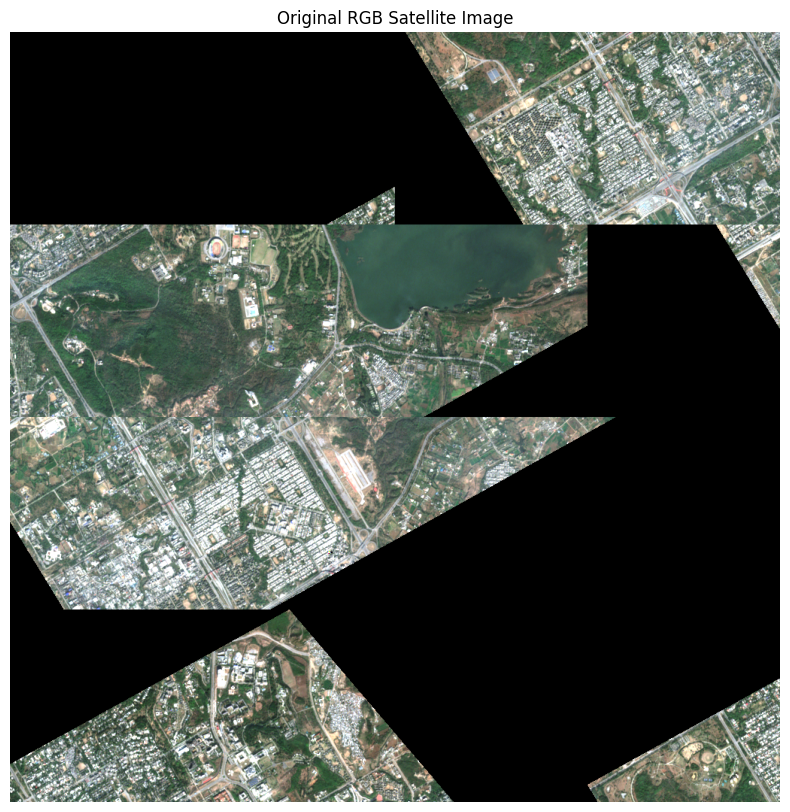

In [25]:

zoomed_tif="/content/zoomed_original.tif"
with rasterio.open(zoomed_tif) as src:
    # Read all three RGB bands
    image = src.read([1, 2, 3])  # RGB bands

    # Display the full RGB image
    rgb_image = np.stack([image[0], image[1], image[2]], axis=-1)  # Combine RGB bands
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb_image)
    plt.title("Original RGB Satellite Image")
    plt.axis("off")
    plt.show()